In [1]:
# Datenzugriff
from configs.path_manager import get_path
from models import db, Routing, Job

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check
from src.utils.production_process import initialize as init

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation


# Extern
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.min_rows', 15)
pd.set_option('display.max_rows', 21)

### Routings

In [2]:
db.connect()

# Routing-Einträge abfragen
query = Routing.select()

records = [{
    "Routing_ID": r.routing,
    "Operation": r.operation,
    "Machine": r.machine,
    "Processing Time": r.duration
} for r in query]

db.close()
df_routings = pd.DataFrame(records)
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
6,0,6,M06,62
...,...,...,...,...
93,9,3,M06,7
94,9,4,M08,64


In [3]:
day_count = 360

df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = day_count, shift_length = 1440,
                                                        u_b_mmax = 0.9, shuffle = True
                                                       )
df_jobs_arrivals

,Job,Routing_ID,Arrival,Ready Time
0,J25-0000,8,79,1440
1,J25-0001,6,129,1440
2,J25-0002,0,198,1440
3,J25-0003,2,243,1440
4,J25-0004,3,287,1440
5,J25-0005,1,498,1440
6,J25-0006,9,790,1440
...,...,...,...,...
7243,J25-7243,5,518075,518400
7244,J25-7244,3,518085,518400


In [4]:
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
6,J25-0000,8,6,M06,40
...,...,...,...,...,...
72493,J25-7249,4,3,M05,61
72494,J25-7249,4,4,M03,26


## I. Simulation

In [5]:
df_problem = df_jssp.merge(
    df_jobs_arrivals[['Job', 'Routing_ID','Arrival', 'Ready Time']],
    on=['Job', 'Routing_ID'],
    how='left'
)
df_problem

,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time
0,J25-0000,8,0,M00,76,79,1440
1,J25-0000,8,1,M01,69,79,1440
2,J25-0000,8,2,M03,76,79,1440
3,J25-0000,8,3,M05,51,79,1440
4,J25-0000,8,4,M02,85,79,1440
5,J25-0000,8,5,M09,11,79,1440
6,J25-0000,8,6,M06,40,79,1440
...,...,...,...,...,...,...,...
72493,J25-7249,4,3,M05,61,518302,518400
72494,J25-7249,4,4,M03,26,518302,518400


In [6]:
simulation = ProductionSimulation(df_problem, earliest_start_column = "Ready Time", verbose= False, sigma=0)
df_fcfs_execution = simulation.run(start_time = 0, end_time=None)
df_fcfs_execution

,Job,Routing_ID,Operation,Machine,Arrival,Ready Time,Start,Processing Time,End
0,J25-0000,8,0,M00,79,1440,1440.0,76.0,1516.0
1,J25-0000,8,1,M01,79,1440,1915.0,69.0,1984.0
2,J25-0000,8,2,M03,79,1440,2017.0,76.0,2093.0
3,J25-0000,8,3,M05,79,1440,2093.0,51.0,2144.0
4,J25-0000,8,4,M02,79,1440,2277.0,85.0,2362.0
5,J25-0000,8,5,M09,79,1440,2362.0,11.0,2373.0
6,J25-0000,8,6,M06,79,1440,2373.0,40.0,2413.0
...,...,...,...,...,...,...,...,...,...
72493,J25-7249,4,3,M05,518302,518400,519533.0,61.0,519594.0
72494,J25-7249,4,4,M03,518302,518400,519877.0,26.0,519903.0


In [7]:
if day_count <= 5:
    show.plot_gantt(df_fcfs_execution, perspective="Machine")

In [8]:
# Letzte Operation je Job auswählen
df_last_ops = df_fcfs_execution.sort_values("Operation").groupby("Job").last().reset_index()
df_jobs_times = df_last_ops[["Job", "Routing_ID", "Arrival", "Ready Time", "End"]]

# Gesamtbearbeitungszeit
df_proc_time = df_jssp.groupby("Job", as_index=False)["Processing Time"].sum()

# Merge
df_jobs_times = df_jobs_times.merge(df_proc_time, on="Job", how="left")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time
0,J25-0000,8,79,1440,2704.0,597
1,J25-0001,6,129,1440,2336.0,416
2,J25-0002,0,198,1440,2925.0,395
3,J25-0003,2,243,1440,2801.0,568
4,J25-0004,3,287,1440,2697.0,655
5,J25-0005,1,498,1440,2630.0,510
6,J25-0006,9,790,1440,2905.0,540
...,...,...,...,...,...,...
7243,J25-7243,5,518075,518400,520377.0,496
7244,J25-7244,3,518085,518400,520251.0,655


## II. Log-Normalverteilung

In [9]:
def add_groupwise_lognormal_deadlines_by_group_mean(df: pd.DataFrame, sigma: float = 0.2,
                                                    routing_column: str = "Routing_ID", seed: int = 42) -> pd.DataFrame:
    """
    Für jede Gruppe in 'Routing_ID' wird eine Lognormalverteilung
    mit Parameter mu so berechnet, dass der Mittelwert der Deadlines genau
    dem Mittelwert der 'End'-Werte der Gruppe entspricht.

    Jeder Deadline-Wert in der Gruppe wird einzeln zufällig aus dieser Verteilung gezogen.

    Parameters
    ----------
    df : pd.DataFrame
        Muss Spalten routing_column und 'End' enthalten.
    sigma : float, optional
        Standardabweichung der Lognormalverteilung (Default 0.2).
    seed : int
        Zufalls-Seed (Default 42).

    Returns
    -------
    pd.DataFrame
        Kopie von df mit neuer Spalte 'Deadline' (float, 1 Dezimalstelle).
    """
    np.random.seed(seed)
    df_out = df.copy()
    df_out['Deadline'] = np.nan

    for routing_id, grp in df_out.groupby(routing_column):
        target_flow_mean = grp['End'].mean() - grp['Ready Time'].mean()
        mu = np.log(target_flow_mean) - 0.5 * sigma**2

        # Für jede Zeile in Gruppe eine Deadline aus LogNormal(mu, sigma)
        flow_budgets = np.random.lognormal(mean=mu, sigma=sigma, size=len(grp))
        df_out.loc[grp.index, 'Deadline'] = df_out.loc[grp.index, 'Ready Time'] + np.round(flow_budgets) 

    return df_out

In [10]:
df_times = add_groupwise_lognormal_deadlines_by_group_mean(df_jobs_times, sigma=0.3)
df_times

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660.0
1,J25-0001,6,129,1440,2336.0,416,2338.0
2,J25-0002,0,198,1440,2925.0,395,3744.0
3,J25-0003,2,243,1440,2801.0,568,3379.0
4,J25-0004,3,287,1440,2697.0,655,4856.0
5,J25-0005,1,498,1440,2630.0,510,3106.0
6,J25-0006,9,790,1440,2905.0,540,3539.0
...,...,...,...,...,...,...,...
7243,J25-7243,5,518075,518400,520377.0,496,520072.0
7244,J25-7244,3,518085,518400,520251.0,655,520389.0


## III. Plot der Verteilung

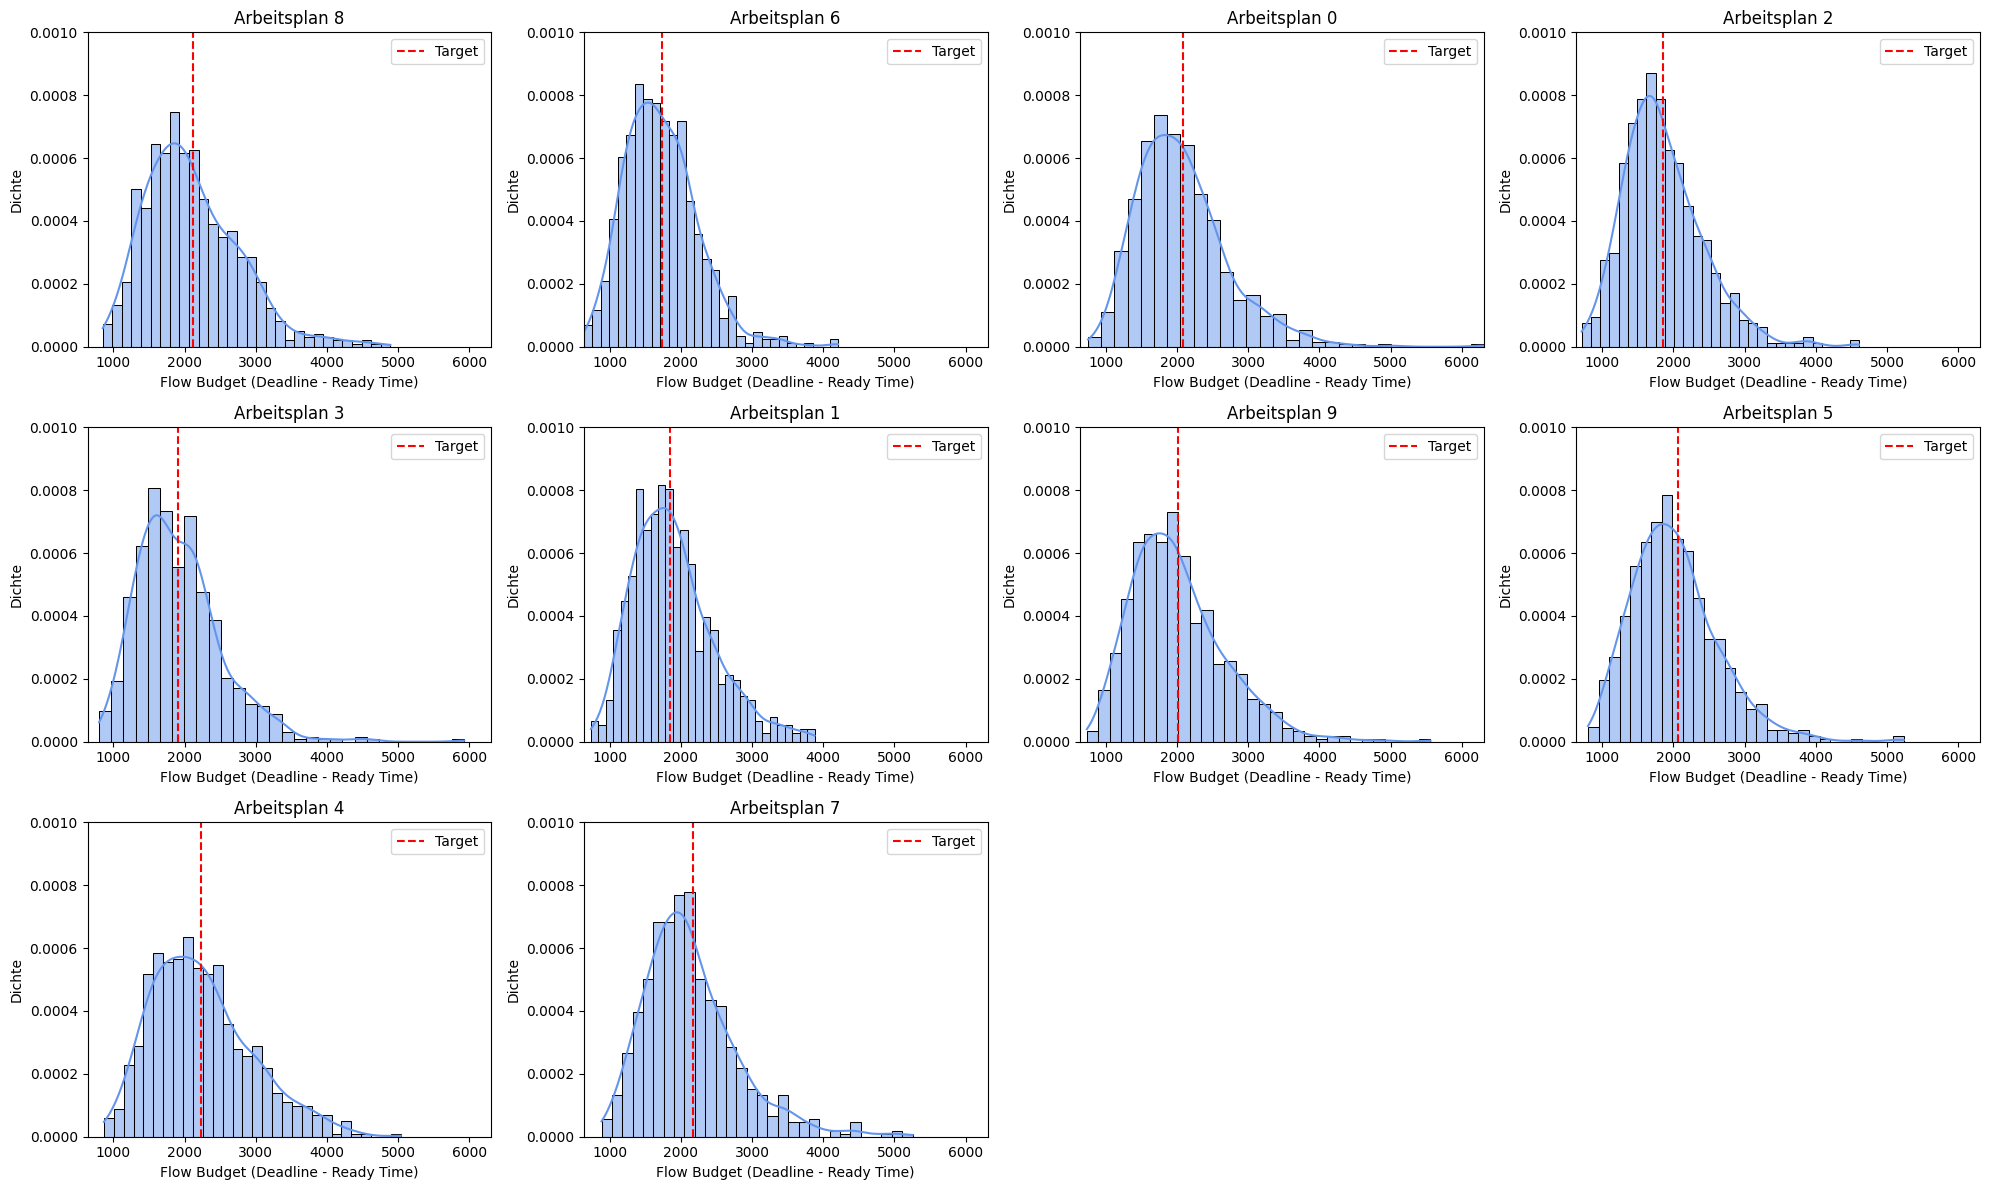

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_empirical_flow_budget_distributions(df_times: pd.DataFrame, bins: int = 30, y_max: float = 0.001):
    """
    Plottet für jede Gruppe in 'Routing_ID' das Histogramm + KDE
    der Flow Budgets (Deadline - Ready Time) auf Basis von df_times.
    Zusätzlich wird der Zielwert (End.mean - Ready Time.mean) als rote Linie eingezeichnet.
    Alle Subplots verwenden dieselbe X- und Y-Achse.

    Parameters
    ----------
    df_times : pd.DataFrame
        Muss Spalten 'Routing_ID', 'Deadline', 'Ready Time', 'End' enthalten.
    bins : int
        Anzahl der Bins im Histogramm.
    y_max : float
        Maximaler Y-Wert (Dichte) für die Achsenskalierung. Default ist 0.001.

    Returns
    -------
    fig : matplotlib.figure.Figure
        Die erzeugte Figure mit den Subplots.
    """
    groups = df_times['Routing_ID'].unique()
    n_groups = len(groups)
    n_cols = min(4, n_groups)
    n_rows = int(np.ceil(n_groups / n_cols))

    # Globale X-Achse basierend auf Flow Budgets
    all_flow_budgets = df_times['Deadline'] - df_times['Ready Time']
    x_min, x_max = all_flow_budgets.min(), all_flow_budgets.max()

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)

    for idx, group in enumerate(groups):
        ax = axes[idx // n_cols][idx % n_cols]
        grp = df_times[df_times['Routing_ID'] == group]
        flow_budgets = grp['Deadline'] - grp['Ready Time']
        target = grp['End'].mean() - grp['Ready Time'].mean()

        sns.histplot(flow_budgets, bins=bins, kde=True, stat='density',
                     ax=ax, color='cornflowerblue', edgecolor='black')

        ax.axvline(target, color='red', linestyle='--', label='Target')
        ax.set_title(f'Arbeitsplan {group}')
        ax.set_xlabel('Flow Budget (Deadline - Ready Time)')
        ax.set_ylabel('Dichte')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(0, y_max)
        ax.legend()

    # Leere Plots deaktivieren
    for j in range(idx + 1, n_rows * n_cols):
        fig.delaxes(axes[j // n_cols][j % n_cols])

    plt.tight_layout()
    return fig



fig = plot_empirical_flow_budget_distributions(df_times)
plt.show()

## IV) "Untere Begrenzung" der Deadlines

In [12]:
df_times['Deadline'] = np.maximum(df_times['Deadline'],
                                  df_times['Ready Time'] 
                                  + df_times['Processing Time'] / 2
                                 )



df_times['Deadline'] = np.ceil(df_times['Deadline']).astype(int)
df_times

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
6,J25-0006,9,790,1440,2905.0,540,3539
...,...,...,...,...,...,...,...
7243,J25-7243,5,518075,518400,520377.0,496,520072
7244,J25-7244,3,518085,518400,520251.0,655,520389


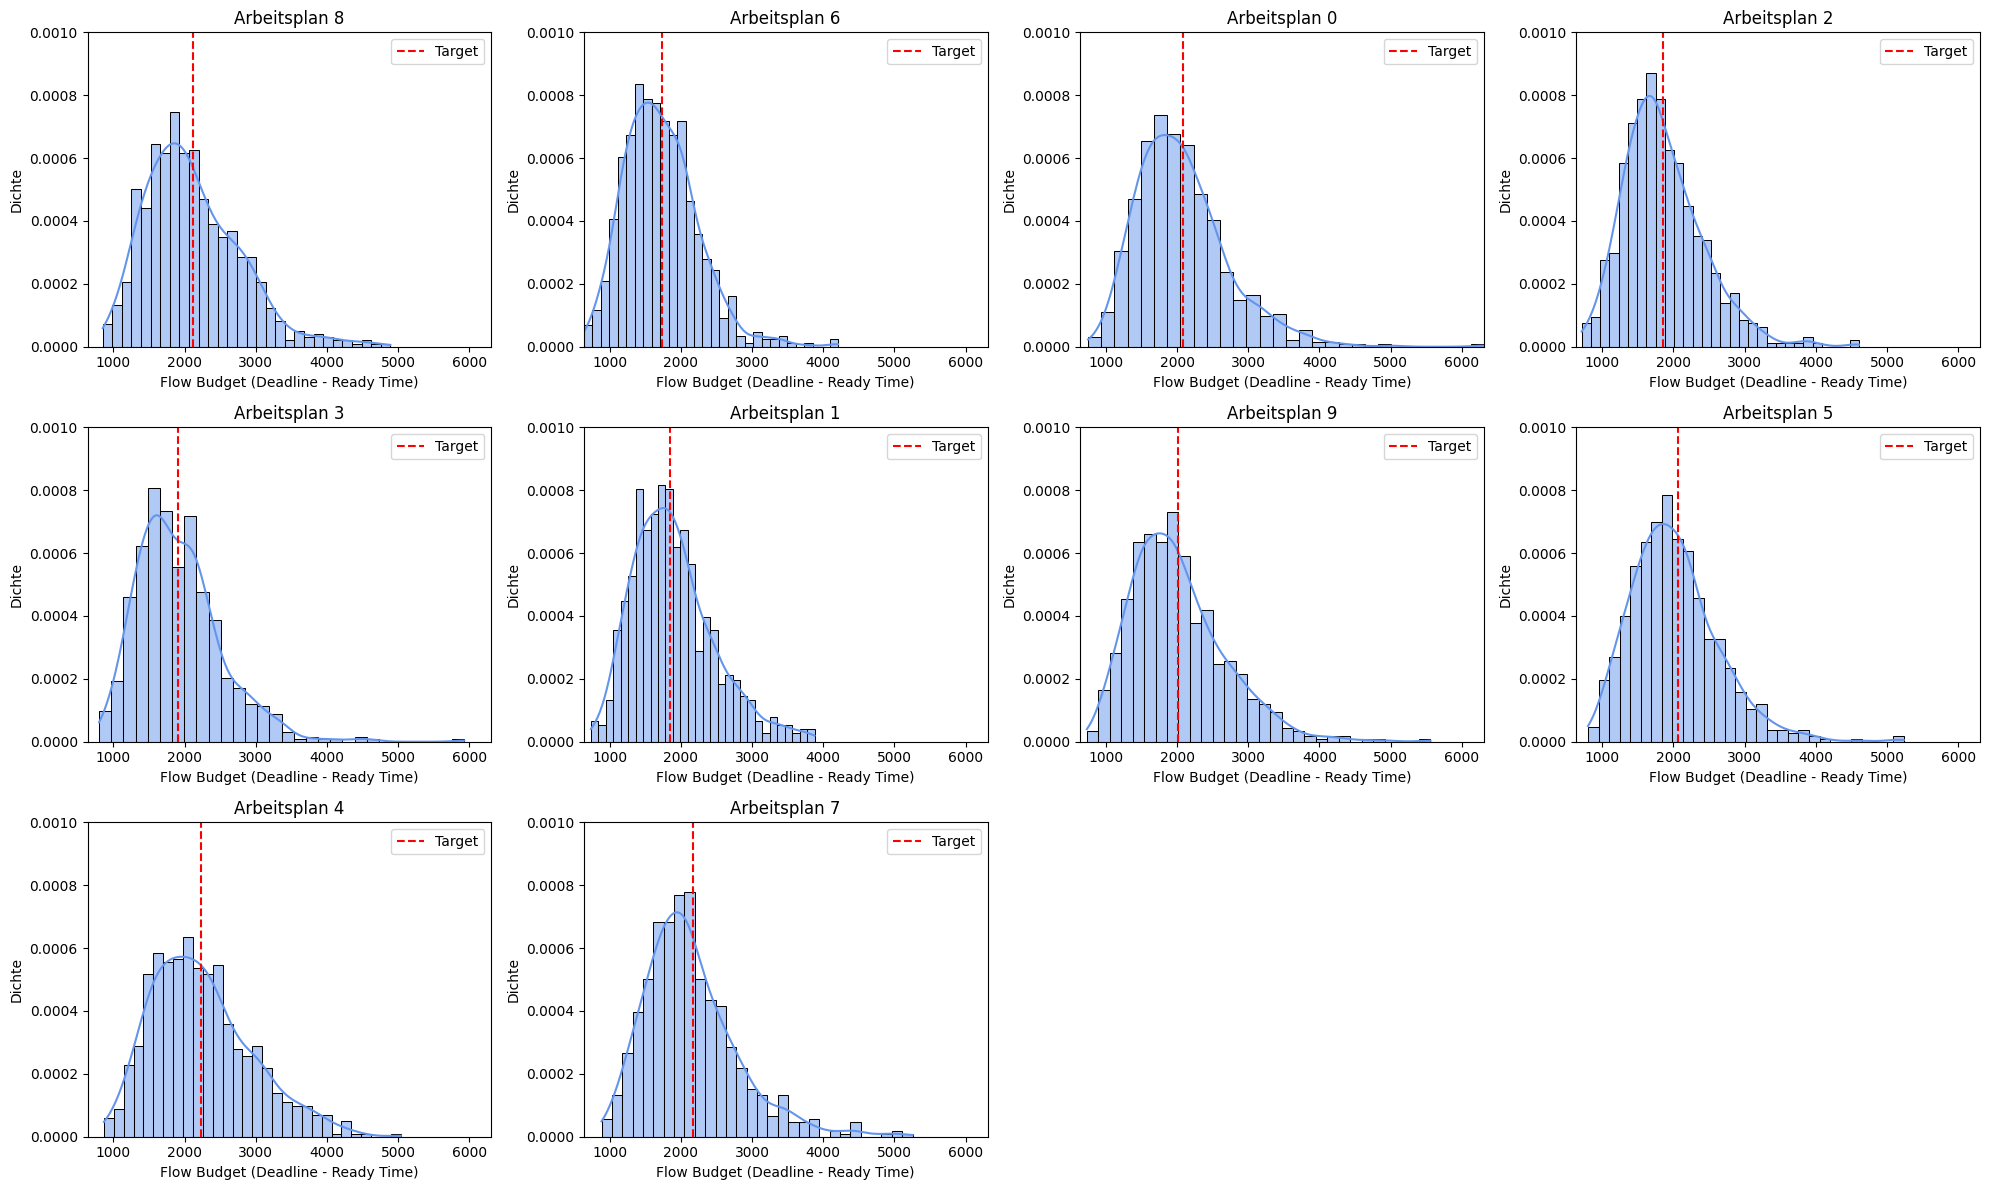

In [13]:
fig = plot_empirical_flow_budget_distributions(df_times)
plt.show()

### Export

In [17]:
Job.create_table()

Job.add_jobs_from_dataframe(df_times, version="base")

✅ Job 'J25-0000' (Version base) wurde hinzugefügt oder aktualisiert.
✅ Job 'J25-0001' (Version base) wurde hinzugefügt oder aktualisiert.
✅ Job 'J25-0002' (Version base) wurde hinzugefügt oder aktualisiert.
✅ Job 'J25-0003' (Version base) wurde hinzugefügt oder aktualisiert.
✅ Job 'J25-0004' (Version base) wurde hinzugefügt oder aktualisiert.
✅ Job 'J25-0005' (Version base) wurde hinzugefügt oder aktualisiert.
✅ Job 'J25-0006' (Version base) wurde hinzugefügt oder aktualisiert.
✅ Job 'J25-0007' (Version base) wurde hinzugefügt oder aktualisiert.
✅ Job 'J25-0008' (Version base) wurde hinzugefügt oder aktualisiert.
✅ Job 'J25-0009' (Version base) wurde hinzugefügt oder aktualisiert.
✅ Job 'J25-0010' (Version base) wurde hinzugefügt oder aktualisiert.
✅ Job 'J25-0011' (Version base) wurde hinzugefügt oder aktualisiert.
✅ Job 'J25-0012' (Version base) wurde hinzugefügt oder aktualisiert.
✅ Job 'J25-0013' (Version base) wurde hinzugefügt oder aktualisiert.
✅ Job 'J25-0014' (Version base) wu

In [18]:
basic_data_path = get_path("data", "basic")
df_times.to_csv(basic_data_path / f"jobs_times_final.csv", index = False)
df_jssp.to_csv(basic_data_path / f"jssp_final.csv", index = False)